# Conformer Refinement with xtb

In a previous notebook on [Confomer Generation in RDKit](https://therealsalmon.github.io/notebooks/rdkit_conf.html), we learned how to use RDKit's ETKDG algorithm to generate conformers and MMFF94 engine to minimize the energy of conformers. However MMFF94 is a very simple treatment of molecular geometries and we may want to go deeper. 

In terms of speed, force fields like MMFF94 are very fast as they calculate molecular energies based on geometric arrangements. However,  as it is not based in quantum mechanics, there is a lot of room for inaccuracy. On the other end of the spectrum are DFT methods that fully solve the quantum mechanics of a molecule to find its energy. These methods take much longer and DFT is the workhorse method for many computational chemists who are looking for accurate molecular geometries. Force field optimizations typically finish in seconds while DFT optimizations may take hours to days!

xtb is an interesting in-between method as it is based off of DFT which hopefully yields the flexibility and accuracy of quantum mechanical methods. However, it is parametrized to approximate the expensive steps in the DFT process resulting in optimizations that finish in 10s of seconds.

This tutorial will not show how to install xtb as it is system-dependent. However, my recommendations are:
* For windows, set up the Ubuntu subsystem and install xtb with conda
* For Linux, install xtb with conda
* For Mac, install xtb with brew

In [160]:
from rdkit import Chem, Geometry
from rdkit.Chem import rdMolAlign
import py3Dmol

# these options customize how our molecules will look when displayed
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (300,200)
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices=False
IPythonConsole.drawOptions.addStereoAnnotation=True
IPythonConsole.drawOptions.baseFontSize=0.7
IPythonConsole.drawOptions.annotationFontScale=1
IPythonConsole.drawOptions.fixedBondLength=20

# these options suppress RDKit errors
from rdkit import RDLogger
rdlogger = RDLogger.logger()
rdlogger.setLevel(RDLogger.CRITICAL)

## subprocess and tempfile

Today we will be calling command-line programs like xtb from python. The easiest way to do this is `os.system` but it typically not recommended for security reasons. Instead, we will be using subprocess.

In [161]:
import subprocess

# ls will list all notebooks in my directory
proc = subprocess.run(['ls'])

__pycache__
autodock_vina.ipynb
conf_utils.py
crest_xtb.ipynb
index.html
nb_convert.py
openmm.ipynb
pharm4.html
pharm4.ipynb
rdkit_conf.html
rdkit_conf.ipynb
rdkit_conf_old.html
rdkit_xtb_conf.ipynb
smarts.html
smarts.ipynb
smarts_old.html
smiles.html
smiles.ipynb
smiles_old.html
update_nb.py


In [162]:
# let's make sure xtb exists on my machine
proc = subprocess.run(['xtb', '--help'])

Usage: xtb [options] <geometry> [options]

<geometry> may be provided as valid TM coordinate file (*coord in Bohr),
in xmol format (*.xyz in Ångström), sdf or mol file format, PDB format
genFormat input or Vasp's POSCAR format.

For a full list visit: https://grimme-lab.github.io/mctc-lib/page/index.html


normal termination of xtb



Options:

-c, --chrg INT
    specify molecular charge as INT, overrides .CHRG file and xcontrol option

-u, --uhf INT
    specify number of unpaired electrons as INT, overrides .UHF file and xcontrol option

--gfn INT
    specify parametrisation of GFN-xTB (default = 2)

--gfnff, --gff
    specify parametrisation of GFN-FF

--oniom METHOD LIST
    use subtractive embedding via ONIOM method. 'METHOD' is given as 'inner:outer'
    where 'inner' can be 'orca', 'turbomole', 'gfn2', 'gfn1', or 'gfnff' and
    'outer' can be 'gfn2', 'gfn1', or 'gfnff'.
    The inner region is given as a comma separated indices directly in the commandline
    or in a file with each index on a separate line.

--etemp REAL
    electronic temperature (default = 300K)

--esp
    calculate electrostatic potential on VdW-grid

--stm
    calculate STM image

-a, --acc REAL
    accuracy for SCC calculation, lower is better (default = 1.0)

--vparam FILE
    Parameter file for vTB calculation

--xparam FILE
    Param

Great, xtb seems ready to go! However, xtb tends to create a lot of extra files as it runs and I personally find the clutter annoying. To avoid this, we will be running things in a temporary directory!

In [163]:
import tempfile

proc = subprocess.run(
    ['pwd'],
    stdout=subprocess.PIPE,
)
# i do a little bit of string manipulation to avoid revealing my file structure
output = proc.stdout.decode().rstrip('\n')
output = output.split('/')
output = f'{"/".join(output[0:2])}/my_username/my_filepath/{"/".join(output[5:7])}'
print(f'pwd normally: {output}')

with tempfile.TemporaryDirectory() as tmp:
    proc = subprocess.run(
        ['pwd'],
        cwd=tmp,
        stdout=subprocess.PIPE,
    )
    output = proc.stdout.decode().rstrip('\n')

print(f'pwd in tempfile: {output}')

pwd normally: /Users/my_username/my_filepath/therealsalmon.github.io/notebooks
pwd in tempfile: /private/var/folders/n8/vbbw9ls578n4msgwm3tg7cr00000gn/T/tmp00q98xl3


## Running xtb

We're ready to give xtb a spin! To do that, we need to create a molecular geometry, save it as a .xyz file, and pass it to xtb. Luckily we have a function for creating molecular geometries from before. Let's import that code!. We'll also bring in our conformer viewer.

In [164]:
from conf_utils import get_low_energy_conformer, display_3d_mol

We can start with a simple system like H2O. We can generate a conformer with our function and then convert it to XYZ coordinates with RDKit.

In [173]:
smi = 'O'
mol = get_low_energy_conformer(smi)

print(Chem.rdmolfiles.MolToXYZBlock(mol))
display_3d_mol(mol)

3

O      0.007544    0.397743    0.000000
H     -0.767103   -0.184393    0.000000
H      0.759559   -0.213350    0.000000



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Here we save the XYZ coordinates of the water molecule as input.xyz and run an xtb geometry optimization job. Let's take a look at the outputs. 

In [174]:
with tempfile.TemporaryDirectory() as tmp:
    Chem.rdmolfiles.MolToXYZFile(mol, f'{tmp}/input.xyz')
    with open(f'{tmp}/xtbopt.out', 'w') as xtbopt_out:
        proc = subprocess.run(
            ['xtb', 'input.xyz', '--opt', '-alpb', 'water'],
            cwd=tmp,
            stdout=xtbopt_out,
            stderr=subprocess.DEVNULL,
        )
    # now let's see what's in our directory
    proc = subprocess.run(['ls'], cwd=tmp)

charges
input.xyz
wbo
xtbopt.log
xtbopt.out
xtbopt.xyz
xtbrestart
xtbtopo.mol


* `charges`: calculated charges for each atom in the order given in the .xyz file
* `input.xyz`: the input file we created
* `wbo`: Wiberg bond orders specified by (atom 1, atom 2, bond order)
* `xtbopt.log`: a trajectory containing multiple XYZ coordinates from the geometry optimization
* `xtbopt.out`: a detailed output file containing all the information about a calculation
* `xtbopt.xyz`: the final optimized geometry
* `xtbrestart`: information for continuing xtb runs, not human-readable
* `xtbtopo.mol`: MOL V2000 file of final optimized geometry

Now that we understand the anatomy of an xtb run, let's extract what we care about, the final energy and geometry. This time, we'll open the xtbopt.xyz file and read it into a string for later.

In [175]:
with tempfile.TemporaryDirectory() as tmp:
    Chem.rdmolfiles.MolToXYZFile(mol, f'{tmp}/input.xyz')
    proc = subprocess.run(
        ['xtb', 'input.xyz', '--opt', '-alpb', 'water'],
        cwd=tmp,
        stdout=subprocess.PIPE,
        stderr=subprocess.DEVNULL,
    )
    with open(f'{tmp}/xtbopt.xyz') as file:
        # first two lines of xyz are atom count and comments
        # last line is blank
        xtb_out = file.read()

print(xtb_out)

energy = float(xtb_out.split('\n')[1].split()[1])
print(f'energy in Hartrees: {energy}')
print(f'energy in kcal/mol: {energy*627.5}\n')

3
 energy: -5.085022288357 gnorm: 0.000148272673 xtb: 6.5.0 (homebrew)
O            0.00723289650955        0.38078007729513       -0.00000000000000
H           -0.77812245537151       -0.17570373161421        0.00000000000000
H            0.77088955886196       -0.20507634568092       -0.00000000000000

energy in Hartrees: -5.085022288357
energy in kcal/mol: -3190.8514859440174



In [176]:
rdkit_mol = Chem.rdchem.Mol(mol)
print('RDKit geometry')
display_3d_mol(rdkit_mol)

mol.RemoveAllConformers()
xtb_xyz = xtb_out.split('\n')[2:-1]
# builds an RDKit conformer from XYZ coordinates
conf = Chem.rdchem.Conformer(mol.GetNumAtoms())
for i, line in enumerate(xtb_xyz):
    ls = line.split()
    x, y, z = float(ls[1]), float(ls[2]), float(ls[3])
    conf.SetAtomPosition(i, Geometry.rdGeometry.Point3D(x, y, z))
mol.AddConformer(conf)
print('xtb geometry')
display_3d_mol(mol)

rmsd = rdMolAlign.AlignMol(mol, rdkit_mol)
print(f'rmsd: {rmsd}')

RDKit geometry


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

xtb geometry


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

rmsd: 0.015073389870022016


That's the basic idea! As you see, the RMSD here is != 0 meaning that the geometry has changed a little. However, it is still quite small which makes sense given that H2O is not a particularly complex molecule. Let's first package our current tooling into a nice little function for later, and then give our new code a spin on some molecules more interesting than water.

In [170]:
def xtb_geom_opt(input_mol: Chem.rdchem.Mol,
                 charge: int = 0,
                 e_state: int = 0,
                 solvent: str = 'water',
                 mmff_max_iters: int = 200) -> Chem.rdchem.Mol:
    """Use xtb to perform a geometry optimization.

    Examples
    --------
    mol = Chem.MolFromSmiles('OCCCO')
    mol = get_low_energy_conformer(mol)
    mol = xtb_geom_opt(mol)

    Parameters
    ----------
    mol: `rdkit.Chem.rdchem.Mol`
        The input RDKit mol object.
    charge: `int`, default = 0
        The total charge of the molecule
    e_state: `int`, default = 0
        N_alpha - N_beta. The difference between the number of spin up and
        spin down electrons. Should usually be 0 unless you are running open
        shell or triplet calculations.
    solvent: `str`, default = ''
        The solvent used for xtb calculations. Choices are acetone,
        acetonitrile, ch2cl2, chcl3, cs2, dmf, dmso, ether, h2o, methanol,
        n-hexane, thf, toluene. The default is no solvent.
    mmff_max_iters: `int`, default = 200
        The number of iterations RDKit's MMFF optimizer will use.

    Returns
    -------
    `rdkit.Chem.rdchem.Mol`
        An RDKit Mol object embedded with an optimized structure."""
    # makes sure that there is a conformer embedded in mol
    mol = Chem.rdchem.Mol(input_mol)
    if len(mol.GetConformers()) == 0:
        mol = get_low_energy_conformer(mol, mmff_max_iters)

    # runs calculations in tmp directory
    with tempfile.TemporaryDirectory() as tmp:
        # create .xyz file in the tmp directory
        Chem.rdmolfiles.MolToXYZFile(mol, f'{tmp}/input.xyz')
        # run xtb on the input file
        xtb_args = ['-c', str(charge), '-u', str(e_state)]
        if solvent != '':
            xtb_args += ['-alpb', solvent]
        proc = subprocess.run(['xtb', 'input.xyz', '--opt'] + xtb_args,
                              cwd=tmp,
                              stdout=subprocess.PIPE,
                              stderr=subprocess.DEVNULL)
        if proc.returncode != 0:
            raise SystemError('xtb abnormal termination')
        with open(f'{tmp}/xtbopt.xyz') as file:
            xtb_out = file.read()

    # add xtb_energy property to mol
    energy = float(xtb_out.split('\n')[1].split()[1])
    mol.SetDoubleProp('xtb_energy_hartrees', energy)
    mol.SetDoubleProp('xtb_energy_kcalmol', energy*627.5)

    # creates a new RDKit Mol with embedded conformer from the xtb xyz output
    xtb_xyz = xtb_out.split('\n')[2:]
    xtb_xyz.remove('')
    mol.RemoveAllConformers()
    conf = Chem.rdchem.Conformer(mol.GetNumAtoms())
    for i, line in enumerate(xtb_xyz):
        ls = line.split()
        x, y, z = float(ls[1]), float(ls[2]), float(ls[3])
        conf.SetAtomPosition(i, Geometry.rdGeometry.Point3D(x, y, z))
    mol.AddConformer(conf)
    return mol

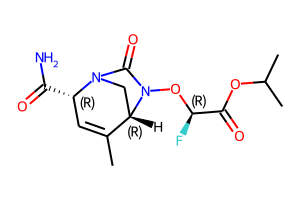

rdkit_mol


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

xtb_mol


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

xtb_energy: -70.883713549402998 Hartrees
rmsd: 1.1284096351620645
----------------------


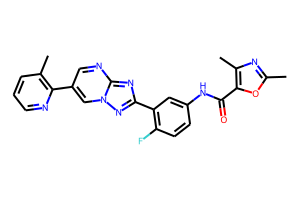

rdkit_mol


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

xtb_mol


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

xtb_energy: -91.852735596510001 Hartrees
rmsd: 0.12617011443392925
----------------------


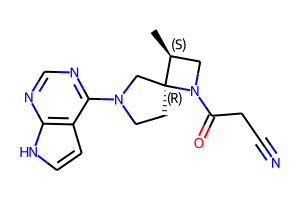

rdkit_mol


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

xtb_mol


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

xtb_energy: -65.115490142531996 Hartrees
rmsd: 0.6493210351601768
----------------------


In [171]:
smiles = [
    'CC1=C[C@@H](N2C[C@@H]1N(C2=O)O[C@@H](C(=O)OC(C)C)F)C(=O)N',
    'CC1=C(N=CC=C1)C2=CN3C(=NC(=N3)C4=C(C=CC(=C4)NC(=O)C5=C(N=C(O5)C)C)F)N=C2',
    'C[C@H]1CN([C@]12CCN(C2)C3=NC=NC4=C3C=CN4)C(=O)CC#N'
]

for smi in smiles:
    mol = Chem.MolFromSmiles(smi)
    display(mol)
    rdkit_mol = get_low_energy_conformer(mol)
    print('rdkit_mol')
    display_3d_mol(rdkit_mol)

    xtb_mol = xtb_geom_opt(rdkit_mol)
    print('xtb_mol')
    display_3d_mol(xtb_mol)

    print(f'xtb_energy: {xtb_mol.GetProp("xtb_energy_hartrees")} Hartrees')

    rmsd = rdMolAlign.AlignMol(xtb_mol, rdkit_mol)
    print(f'rmsd: {rmsd}')
    print('----------------------')

As we can see, some of the RMSD values are >0.5, meaning that the RDKit and xtb geometries are substantially different. While we'd have to do a benchmark to fully characterize the impact of doing this conformer refinement, hopefully found this intro to xtb and the application of semi-empirical quantum mechanical methods useful.